In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from numpy.core.numeric import full
import pickle
import time
import random 
import pprint
import warnings
from collections import Counter
from scipy.spatial import distance
from operator import itemgetter


from copy import deepcopy

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

from skimage.color import gray2rgb, rgb2gray, label2rgb

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, UpSampling2D, BatchNormalization, Activation, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical



# from keras.layers import Input, Dense, Activation, Lambda, Reshape, Flatten
# from keras.layers import BatchNormalization
# from keras import losses
# from keras import backend as K
# from keras.losses import mse
# from keras.optimizers import Adam

import tensorflow as tf



# LIME
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries, slic
from scipy import ndimage

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from PIL import Image


from ANM_components import *   

2024-01-09 14:47:29.349567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load the model
model = load_model('NN4.h5')

2024-01-09 14:47:36.861900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
print("Data shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Load the feature activations
X_train_act = np.load("X_train_act.npy")
X_test_act = np.load("X_test_act.npy")
print("Activation shapes:", X_train_act.shape, X_test_act.shape)

# Load DeepLIFT contributions
X_train_cont = np.load("new_X_train_deeplift.npy")
X_test_cont = np.load("new_X_test_deeplift.npy")
print("contributions shapes:", X_train_cont.shape, X_test_cont.shape)

oh_y_train = to_categorical(y_train)
oh_y_test = to_categorical(y_test)

Data shapes: (60000, 1, 28, 28) (10000, 1, 28, 28) (60000,) (10000,)
Activation shapes: (0,) (0,)
contributions shapes: (60000, 128) (10000, 128)


In [4]:
# Load the top feature dictionary (after LIME, aggregation, SAGE, clustering)
clustered_top_features = np.load('clustered_top_features.npy', allow_pickle=True).item()

#print key value pairs
for key, value in clustered_top_features.items():
    print(key, value)

0 [{'importance': 3.8465019315481186e-05, 'mask': array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False

## Contributions Search

In [5]:
X_train_knn = X_train.reshape(X_train.shape[0], 28*28)
X_test_knn = X_test.reshape(X_test.shape[0], 28*28)

In [6]:
print("DeepLIFT-KNN:", X_train_cont.shape)
print("Activations:", X_train_act.shape)
print("Training:", X_train.shape)
print("Training k-NN:", X_train_knn.shape)
print("y_test:", y_test.shape)

DeepLIFT-KNN: (60000, 128)
Activations: (0,)
Training: (60000, 1, 28, 28)
Training k-NN: (60000, 784)
y_test: (10000,)


In [7]:
# # Reshape from NCHW to NHWC

X_train = np.transpose(X_train, (0, 2, 3, 1))
X_test = np.transpose(X_test, (0, 2, 3, 1))



# First get the probabilities
nn_prob = model.predict(X_test)

# Then get the class labels
nn_pred = np.argmax(nn_prob, axis=1)

313/313 [==============================] - 1s 4ms/step


In [8]:
print("Shape of X_test:", X_test.shape)


Shape of X_test: (10000, 28, 28, 1)


In [9]:
techniques = [
    #["k-NN*", X_train_act, X_test_act],
    ["C-DeepLIFT", X_train_cont, X_test_cont]
             ]

for item in techniques:
    technique = item[0]
    train = item[1]
    test = item[2]

    print("==================================================")
    print(technique)
    print("==================================================")

    kNN = KNeighborsClassifier(n_neighbors=3, algorithm="brute") 
    kNN.fit(train, y_train)

    knn_predictions_test = kNN.predict(test)
    print("Accuracy:", accuracy_score(y_test, knn_predictions_test))
    print(confusion_matrix(y_test, knn_predictions_test, labels=None, sample_weight=None))
    print(" ")
    
    # What's the % that's different?
    correct = 0
    for i in range(len(nn_pred)):
        if knn_predictions_test[i] == nn_pred[i]:
            correct += 1
    print("Agreement", correct/len(nn_pred))



C-DeepLIFT
Accuracy: 0.9764
[[950  44   0   0   2   0   0   0   4   0]
 [  4 993   0   2   0   0   0   0   0   1]
 [  2   0 996   0   0   0   0   1   1   0]
 [  1   6   2 956   3  12   3  17   0   0]
 [  0   0   1   0 990   0   1   3   4   1]
 [  1   0   1   1  29 967   0   1   0   0]
 [  0   0   0   0   4   1 974   1   1  19]
 [  8   1   2   6   3   0  32 946   1   1]
 [  2   0   0   0   1   0   0   0 996   1]
 [  1   0   0   0   0   0   1   0   2 996]]
 
Agreement 0.9761


In [10]:
distances, idxs = kNN.kneighbors(X=[X_test_cont[5]], n_neighbors=1, return_distance=True)
neighbour = idxs[0][0]
explanation = y_train[neighbour]

In [11]:
model.predict(np.array([X_test[i]]))[0] == explanation

1/1 [==============================] - 0s 29ms/step


array([False, False, False, False, False, False, False, False, False,
       False])

In [12]:
#x_test shape
X_test.shape

# X_train.shape

(10000, 28, 28, 1)

In [13]:
# # Initialize your frequency dictionary
# freq_dict = {i: [] for i in range(1, 9)}

# # Loop through each digit class
# digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# # Preallocate arrays
# train_batch = []
# test_batch = []
# indices = []

# # Run the loop
# for digit in digits:
#     for i in range(len(X_test)):
#         if y_test[i] == digit:
#             # Find Neighbour label and predicted label
#             _, idxs = kNN.kneighbors(X=[X_test_cont[i]], n_neighbors=3)
#             neighbour_idx = idxs[0][0]

#             # Correct the shape of your sample
#             single_train_sample = np.expand_dims(X_train[neighbour_idx], axis=0).astype('float32')
#             single_test_sample = np.expand_dims(X_test[i], axis=0).astype('float32')

#             # Append to batch
#             train_batch.append(single_train_sample)
#             test_batch.append(single_test_sample)
#             indices.append((i, neighbour_idx))

# # Convert lists to arrays
# train_batch = np.vstack(train_batch)
# test_batch = np.vstack(test_batch)

# # Batch prediction
# train_preds = np.argmax(model.predict(train_batch), axis=-1)
# test_preds = np.argmax(model.predict(test_batch), axis=-1)

# # Populate freq_dict
# for i, (test_idx, train_idx) in enumerate(indices):
#     CNN_pred = test_preds[i]
#     exp_pred = train_preds[i]
#     exp_label = y_train[train_idx]
#     digit = y_test[test_idx]
    
#     if CNN_pred == exp_pred:
#         freq_dict[1 if CNN_pred == exp_label == digit else 4].append(test_idx)
#     else:
#         freq_dict[5 if CNN_pred == exp_label == digit else 8].append(test_idx)


In [14]:
# freq_dict = {1:[], 2:[]}

# digits = [0,1,2,3,4,5,6,7,8,9]

# for digit in digits:

#     for i in range(len(X_test)): 

#         # Not terribly efficient code, but it'll do here
#         if y_test[i] == digit:

#             # Find Neighbour label and predicted label
#             neighbour_idxs = kNN.kneighbors(X=[X_test_cont[i]], n_neighbors=3, return_distance=False)
            
#             neighbour_idxs = neighbour_idxs[0]
#             neighbour_labels = deepcopy(neighbour_idxs)
#             neighbour_preds = deepcopy(neighbour_idxs)
            
#             for j in range(len(neighbour_idxs)):
#                 neighbour_labels[j] = y_train[neighbour_idxs[j]]
#                 neighbour_preds[j] = np.argmax(model.predict(np.array([X_train[neighbour_idxs[j]]])), axis=-1)[0]

            
#             CNN_pred = np.argmax(model.predict(np.array([X_test[i]])), axis=-1)[0]
#             query_label = y_test[i]
            
        
#             # Situation 1
#             if CNN_pred != query_label:
#                 if len(Counter(neighbour_labels)) == 1 and len(Counter(neighbour_preds)) == 1:
#                     if neighbour_labels[0] == neighbour_preds[0]:
#                         if neighbour_labels[0] == CNN_pred:
#                             freq_dict[1].append(i)
                    
#             # Situation 2       
#             if CNN_pred != query_label:
#                 if len(Counter(neighbour_labels)) == 2:
#                     if Counter(neighbour_labels).most_common()[0][0] == CNN_pred:
#                         freq_dict[2].append(i)


# # save freq_dict
# with open('freq_dict2.pkl', 'wb') as f:
#     pickle.dump(freq_dict, f)
    
#load freq_dict 
with open('freq_dict2.pkl', 'rb') as f:
    freq_dict = pickle.load(f)

## Examine Explanation with White Box

In [15]:
kNN = KNeighborsClassifier(n_neighbors=3, algorithm="brute") 
kNN.fit(X_train_cont, y_train)
knn_predictions_test = kNN.predict(X_test_cont)

In [16]:
accuracy_score(y_test, knn_predictions_test)

0.9764

In [17]:
# Pull list of errors to examine

freq_dict

{1: [1530,
  1580,
  1660,
  1700,
  1710,
  1740,
  1780,
  1810,
  1820,
  1860,
  1870,
  1950,
  1980,
  2020,
  2110,
  2180,
  2190,
  2310,
  2340,
  2540,
  3080,
  5460,
  6140,
  6350,
  7700,
  7710,
  7740,
  7770,
  7900,
  7920,
  8070,
  8270,
  8300,
  8410,
  8450,
  8650,
  8770,
  8780,
  5611,
  5651,
  6351,
  1892,
  2142,
  7712,
  1773,
  1853,
  2103,
  2533,
  5063,
  5393,
  5553,
  5733,
  5743,
  5893,
  7213,
  7283,
  7413,
  7653,
  8403,
  9103,
  9193,
  9273,
  9413,
  9533,
  9943,
  1464,
  1504,
  1874,
  1904,
  8544,
  215,
  865,
  965,
  1005,
  1055,
  1065,
  1075,
  6645,
  6725,
  6835,
  7005,
  1646,
  1806,
  2066,
  7746,
  8066,
  8096,
  8146,
  8256,
  8346,
  8366,
  8386,
  8426,
  8456,
  8546,
  8586,
  8776,
  827,
  1347,
  1377,
  1387,
  1597,
  1627,
  1667,
  1677,
  1687,
  1737,
  1787,
  1867,
  1947,
  2307,
  2537,
  2547,
  2557,
  2667,
  4937,
  6537,
  7057,
  7097,
  7127,
  7137,
  7177,
  7217,
  7287,
  7657,
 

## Initial view of classifications. 

All misclassifications are stored in the freq_dict, correct classifications are any datapoints not in the freq_dict.

TI Ground Truth: 7
1/1 [==============================] - 0s 27ms/step
Predicted Class/NN Ground Truth: 7
 
Neighbors:
3
3
3
 
1/1 [==============================] - 0s 24ms/step


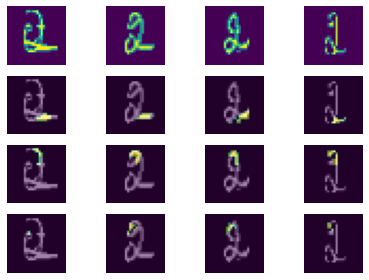

In [18]:
def get_overlapping_feature(image, feature_mask):
    # Ensure that both inputs are of shape (28, 28, 1)
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    if len(feature_mask.shape) == 2:
        feature_mask = np.expand_dims(feature_mask, axis=-1)

    overlapping = np.logical_and(image, feature_mask).astype(int)
    return overlapping


# Function to evaluate the presence of a feature in an image
def evaluate_feature_presence(image, feature_mask):
    presence = np.sum(image * feature_mask) / np.sum(feature_mask)  # Normalised
    return round(presence, 4)

test_instance = 7717

# Find Neighbours
idxs = kNN.kneighbors(X=[X_test_cont[test_instance]], n_neighbors=3, return_distance=False)
neighbours = idxs[0]

print("TI Ground Truth:", y_test[test_instance])
print("Predicted Class/NN Ground Truth:", np.argmax(model.predict(np.array([X_test[test_instance]])), axis=-1)[0])
print(" ")
print("Neighbors:")
for i in range(len(neighbours)):
    print(y_train[neighbours[i]])
print(" ")

# Assess the query test instance
target_class = y_test[test_instance]
predicted_class = np.argmax(model.predict(np.array([X_test[test_instance]])), axis=-1)[0]
neighbor_class = np.argmax(model.predict(np.array([X_test[test_instance]])), axis=-1)[0]

# Original images
f, axarr = plt.subplots(4, 4)  # Adjusting to include 3 features + original

axarr[0, 0].imshow(np.squeeze(X_test[test_instance]), cmap='viridis')
axarr[0, 0].axis('off')

for i, neighbour in enumerate(neighbours):
    axarr[0, i+1].imshow(np.squeeze(X_train[neighbour]), cmap='viridis')
    axarr[0, i+1].axis('off')

# For each of the top 3 features
for feature_idx in range(3):
    # The mask for the current feature
    feature_mask = clustered_top_features[predicted_class][feature_idx]['mask']
    
    # Images with overlapping feature activation overlay
    for i, neighbour in enumerate([test_instance] + list(neighbours)):
        original_image = np.squeeze(X_test[test_instance] if i == 0 else X_train[neighbours[i-1]])
        overlapping_feature = get_overlapping_feature(original_image, feature_mask)
        
        axarr[feature_idx + 1, i].imshow(original_image, cmap='gray')
        axarr[feature_idx + 1, i].imshow(overlapping_feature, cmap='viridis', alpha=0.5)
        axarr[feature_idx + 1, i].axis('off')

plt.tight_layout()
plt.show()


In [19]:
# 1. Get predictions for test data.
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=-1)

# 2. Compare the predictions with the true labels and get indices of misclassifications.
misclassified_indices = np.where(predicted_labels != y_test)[0]

# 3. Use those indices to extract the corresponding data points from the test data.
misclassified_instances = [X_test[i] for i in misclassified_indices]

# Print out the number of misclassified instances to confirm
print(len(misclassified_instances))


313/313 [==============================] - 2s 5ms/step
348


#### Prototypes

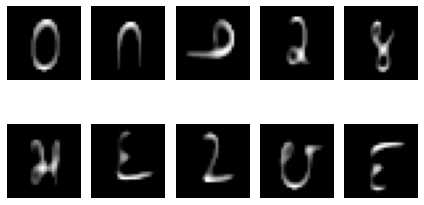

In [20]:
centroids = {}
for label in np.unique(y_train):
    class_indices = np.where(y_train == label)[0]
    class_images = X_train[class_indices]
    
    # Compute the median image
    median_image = np.median(class_images, axis=0)
    centroids[label] = median_image


# Generate the combined prototypes using centroids + top features
prototypes = {}
for class_id, features in clustered_top_features.items():
    prototype = np.copy(centroids[class_id])
    
    for feature in features:
        # Overlay the feature onto the centroid
        overlapping_feature = get_overlapping_feature(prototype, feature['mask'])
        
        # # Print the shapes for debugging
        # print("Prototype shape:", prototype.shape)
        # print("Overlapping feature shape:", overlapping_feature.shape)
        
        # Ensure the shapes are compatible before adding
        prototype = np.squeeze(prototype)
        overlapping_feature = np.squeeze(overlapping_feature)
        
        prototype += overlapping_feature
        
    # Normalize to ensure values are within valid range (0-1 for grayscale, for example)
    prototype = np.clip(prototype, 0, 1)
    prototypes[class_id] = prototype

# Display the centroids 
f, axarr = plt.subplots(2, 5)

for i in range(2):
    for j in range(5):
        axarr[i, j].imshow(centroids[i*5 + j], cmap='gray')
        axarr[i, j].axis('off')

plt.tight_layout()


1/1 [==============================] - 0s 59ms/step
Total loss for original neighbor 1: -26.72065544128418
Total loss for original neighbor 2: -34.38178253173828
Total loss for original neighbor 3: -37.44544982910156
1/1 [==============================] - 0s 22ms/step
Total loss for new neighbor 1: -36.46369934082031
Total loss for new neighbor 2: -18.47499656677246
Total loss for new neighbor 3: -40.02911376953125


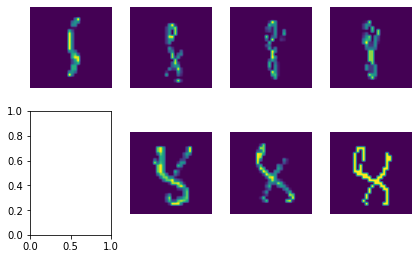

In [28]:
## Initial ANM before refinement ##

test_instance = 2066
idxs = kNN.kneighbors(X=[X_test_cont[test_instance]], n_neighbors=3, return_distance=False)
neighbours = idxs[0]

target_class = y_test[test_instance]
predicted_class = np.argmax(model.predict(np.array([X_test[test_instance]])), axis=-1)[0]

def compute_total_loss(datapoint, target_class, neighbor_class, prototypes, clustered_top_features, rho, delta, model):
    datapoint_tensor = tf.convert_to_tensor(datapoint.reshape((1, 28, 28, 1)), dtype=tf.float32)
    logits = model(datapoint_tensor)
    L_boundary = compute_L_boundary(logits, target_class)
    L_feature = compute_L_feature(datapoint_tensor, rho, target_class, neighbor_class, prototypes, clustered_top_features, target_weight=1, neighbor_weight=1)
    L_directionality = compute_L_directionality(datapoint_tensor, datapoint_tensor, delta, model, target_class, neighbor_class, prototypes)
    total_loss = L_boundary + L_feature + L_directionality
    return total_loss.numpy() if hasattr(total_loss, 'numpy') else total_loss

# Initialise a list to store the total loss for each neighbour
neighbor_losses = []
rho = 5.0
delta = 0.1

# Compute the total loss for each original neighbour
for neighbor in neighbours:
    neighbor_class = y_train[neighbor]  
    neighbor_loss = compute_total_loss(
        X_train[neighbor],
        target_class,
        neighbor_class,
        centroids,
        clustered_top_features,
        rho,
        delta,
        model
    )
    neighbor_losses.append(neighbor_loss)

# Print the total loss for each original neighbour
for i, loss in enumerate(neighbor_losses):
    print(f"Total loss for original neighbor {i+1}: {loss}")

# Define a function to compute a combined score for sorting
def combined_score(loss, distance):
    return loss - (0.1 * distance)  # Simple version of combining loss and distance

candidate_indices = np.where(y_train == neighbor_class)[0]

# Initialise a list to store the total loss for each data point
new_losses = []

# Iterate over the dataset
for i in candidate_indices:
    datapoint = X_train[i]
    loss = compute_total_loss(datapoint, target_class, neighbor_class, prototypes, clustered_top_features, rho, delta, model)
    distance = np.linalg.norm(datapoint - X_test[test_instance])
    combined = combined_score(loss, distance)
    new_losses.append((combined, i))


# Sort by the combined score (descending)
new_losses.sort(reverse=True)

# Select the top N indices with the highest combined score for weighted random sampling
N = 30
top_losses = new_losses[:N]
top_loss_values, top_loss_indices = zip(*top_losses)
loss_probabilities = np.array(top_loss_values)
loss_probabilities /= loss_probabilities.sum()  # Normalise to sum to 1

# Randomly choose 3 indices based on the loss probabilities
random_neighbors_indices = np.random.choice(top_loss_indices, size=3, replace=False, p=loss_probabilities)

# Get the class of the original neighbor
neighbor_class = np.argmax(model.predict(np.array([X_train[neighbours[0]]])), axis=-1)[0]

# Find candidate indices with the same class as the original neighbor
candidate_indices = np.where(y_train == neighbor_class)[0]

# Initialise a list to store the total loss for each data point
new_losses = []

# Iterate over the dataset
for i in candidate_indices:
    datapoint = X_train[i]
    loss = compute_total_loss(datapoint, target_class, neighbor_class, centroids, clustered_top_features, rho, delta, model)
    distance = np.linalg.norm(datapoint - X_test[test_instance])
    combined = combined_score(loss, distance)
    new_losses.append((combined, i))


# Get the corresponding neighbors
random_neighbors = [X_train[idx] for idx in random_neighbors_indices]

# Print the total loss for each new neighbor
for i, idx in enumerate(random_neighbors_indices):
    loss = compute_total_loss(X_train[idx], target_class, neighbor_class, centroids, clustered_top_features, rho, delta, model)
    print(f"Total loss for new neighbor {i+1}: {loss}")

# Visualise the original and new neighbors
f, axarr = plt.subplots(2, 4)
axarr[0, 0].imshow(np.squeeze(X_test[test_instance]), cmap='viridis')
axarr[0, 0].axis('off')
for i, neighbor in enumerate(neighbours):
    axarr[0, i+1].imshow(np.squeeze(X_train[neighbor]), cmap='viridis')
    axarr[0, i+1].axis('off')
for i, neighbor in enumerate(random_neighbors):
    axarr[1, i+1].imshow(np.squeeze(neighbor), cmap='viridis')
    axarr[1, i+1].axis('off')
plt.tight_layout()
plt.show()


#print performance metrics
# execution time
# computational efficiency


In [22]:
# ## Refined ANM approach that focuses on the prototypes ##
# def compute_feature_loss_to_prototype(datapoint, class_index, centroids, top_features, rho, num_features=5):
#     """
#     Compute the feature loss for a data point relative to a class prototype.

#     Parameters:
#     datapoint (np.ndarray): The input data point.
#     class_index (int): The index of the class whose prototype is used.
#     prototypes (dict): A dictionary containing class prototypes.
#     top_features (dict): A dictionary of top features for each class with their masks.
#     rho (float): Scaling factor for the loss.
#     num_features (int): Number of top features to consider.

#     Returns:
#     float: The feature loss relative to the prototype.
#     """
#     instance_tensor = tf.convert_to_tensor(datapoint, dtype=tf.float32)
#     Centroid_class = tf.convert_to_tensor(centroids[class_index], dtype=tf.float32)
    
#     L_feature = tf.constant(0.0, dtype=tf.float32)
    
#     actual_num_features = min(num_features, len(top_features[class_index]))
    
#     for feature_idx in range(actual_num_features):
#         M_class = tf.cast(top_features[class_index][feature_idx]['mask'], dtype=tf.float32)
#         term_class = tf.norm(tf.multiply(M_class, instance_tensor - Centroid_class))
#         L_feature += term_class
    
#     L_feature *= rho
#     return L_feature.numpy()


# # Find Closest Data Points to Prototype for Each Class
# closest_data_points = {}
# rho_value = 5.0  
# num_features_considered = 5  
# num_closest = 15  

# for class_index, proto in centroids.items():
#     class_indices = np.where(y_train == class_index)[0]
#     class_data = X_train[class_indices]
    
#     feature_losses = [compute_feature_loss_to_prototype(datapoint, class_index, centroids, clustered_top_features, rho=rho_value, num_features=num_features_considered) for datapoint in class_data]
#     sorted_indices = np.argsort(feature_losses)
#     closest_indices = class_indices[sorted_indices[:num_closest]]
#     closest_data_points[class_index] = X_train[closest_indices]

# # Visualise Closest Data Points for Each Class
# for class_id, data_points in closest_data_points.items():
#     plt.figure(figsize=(12, 2))
#     for i, img in enumerate(data_points):
#         plt.subplot(1, num_closest, i+1)
#         plt.imshow(np.squeeze(img), cmap='viridis')
#         plt.title(f"{class_id} - {i+1}")
#         plt.axis('off')
#     plt.show()
